# Handwritten Digit Recognition using CNN

This notebook implements a Convolutional Neural Network (CNN) for recognizing handwritten digits using PyTorch.

## 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob

## 2. Set Device Configuration

In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 3. Custom Dataset Class

This class loads images from the archive folder structure where each subfolder (0-9) contains images of that digit.

In [3]:
class HandwrittenDigitDataset(Dataset):
    """
    Custom Dataset for loading handwritten digit images from folder structure.
    Expected structure:
    archive/
        0/
            image1.jpg
            image2.jpg
        1/
            image1.jpg
            ...
        ...
        9/
    """
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the digit folders (0-9)
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load all images and their labels
        for digit in range(10):
            digit_folder = os.path.join(root_dir, str(digit))
            if os.path.exists(digit_folder):
                image_files = glob.glob(os.path.join(digit_folder, '*.jpg')) + \
                              glob.glob(os.path.join(digit_folder, '*.jpeg')) + \
                              glob.glob(os.path.join(digit_folder, '*.png'))
                
                for img_path in image_files:
                    self.images.append(img_path)
                    self.labels.append(digit)
        
        print(f"Loaded {len(self.images)} images from {root_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## 4. Define CNN Architecture

In [4]:
class DigitCNN(nn.Module):
    """
    Convolutional Neural Network for handwritten digit recognition.
    
    Architecture:
    - Conv Layer 1: 1 input channel -> 32 output channels, 3x3 kernel
    - Conv Layer 2: 32 -> 64 channels, 3x3 kernel
    - Conv Layer 3: 64 -> 128 channels, 3x3 kernel
    - Fully Connected Layer 1: 128 * 3 * 3 -> 256 neurons
    - Fully Connected Layer 2: 256 -> 10 neurons (output classes)
    """
    
    def __init__(self):
        super(DigitCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout for regularization
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
    
    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)  # 28x28 -> 14x14
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)  # 14x14 -> 7x7
        
        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)  # 7x7 -> 3x3
        
        x = self.dropout1(x)
        
        # Flatten the tensor
        x = x.view(-1, 128 * 3 * 3)
        
        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

## 5. Data Preprocessing and Loading

In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to 28x28 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),  # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset_path = 'archive'  # Path to the archive folder
full_dataset = HandwrittenDigitDataset(root_dir=dataset_path, transform=transform)

Loaded 2000 images from archive


## 6. Split Dataset into Train, Validation, and Test Sets

In [6]:
# Split dataset: 70% train, 15% validation, 15% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create data loaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training samples: 1400
Validation samples: 300
Test samples: 300


## 7. Visualize Sample Images

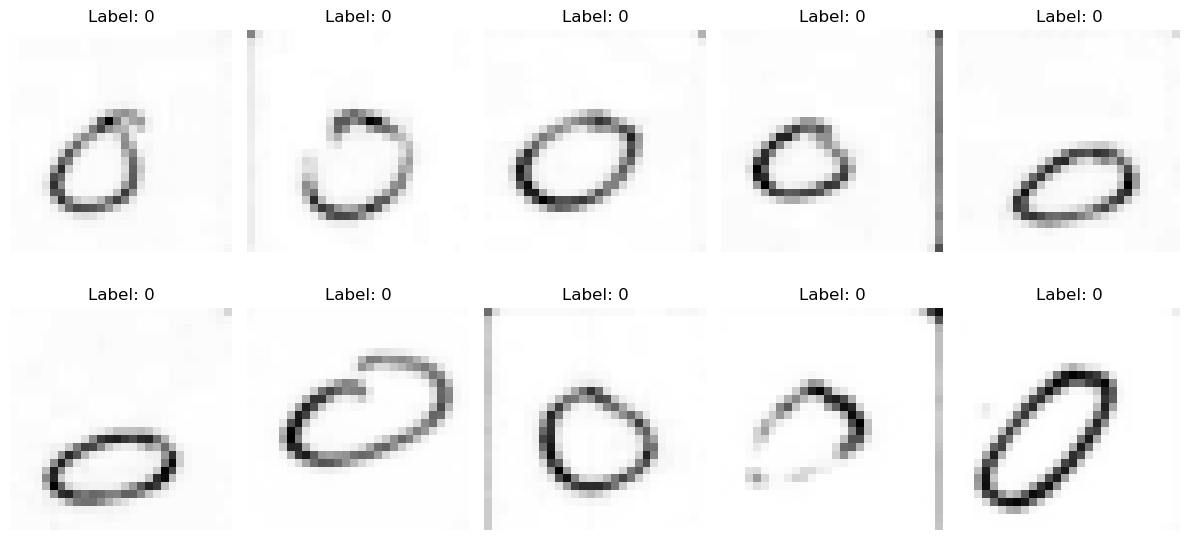

In [7]:
# Display some sample images
def show_sample_images(dataset, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        image, label = dataset[i]
        # Denormalize the image
        image = image.squeeze().numpy() * 0.5 + 0.5
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images(full_dataset)

## 8. Initialize Model, Loss Function, and Optimizer

In [8]:
# Initialize the model
model = DigitCNN().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Print model summary
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

DigitCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Total parameters: 390858
Trainable parameters: 390858


## 9. Training Function

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

## 10. Validation Function

In [10]:
def validate(model, val_loader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

## 11. Train the Model

In [11]:
# Training parameters
num_epochs = 20

# Lists to store training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

print("Starting training...\n")

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  ** Best model saved with validation accuracy: {best_val_acc:.2f}% **")
    print()

print("Training completed!")

Starting training...

Epoch [1/20]
  Train Loss: 2.0779, Train Acc: 27.64%
  Val Loss: 2.0357, Val Acc: 28.00%
  ** Best model saved with validation accuracy: 28.00% **

Epoch [2/20]
  Train Loss: 1.2960, Train Acc: 58.93%
  Val Loss: 1.0781, Val Acc: 63.33%
  ** Best model saved with validation accuracy: 63.33% **

Epoch [3/20]
  Train Loss: 0.7360, Train Acc: 77.43%
  Val Loss: 0.5251, Val Acc: 83.67%
  ** Best model saved with validation accuracy: 83.67% **

Epoch [4/20]
  Train Loss: 0.4601, Train Acc: 86.00%
  Val Loss: 0.3413, Val Acc: 90.67%
  ** Best model saved with validation accuracy: 90.67% **

Epoch [5/20]
  Train Loss: 0.2952, Train Acc: 90.79%
  Val Loss: 0.2163, Val Acc: 94.00%
  ** Best model saved with validation accuracy: 94.00% **

Epoch [6/20]
  Train Loss: 0.2100, Train Acc: 94.50%
  Val Loss: 0.1733, Val Acc: 95.00%
  ** Best model saved with validation accuracy: 95.00% **

Epoch [7/20]
  Train Loss: 0.1742, Train Acc: 95.64%
  Val Loss: 0.2153, Val Acc: 93.00%



## 12. Plot Training History

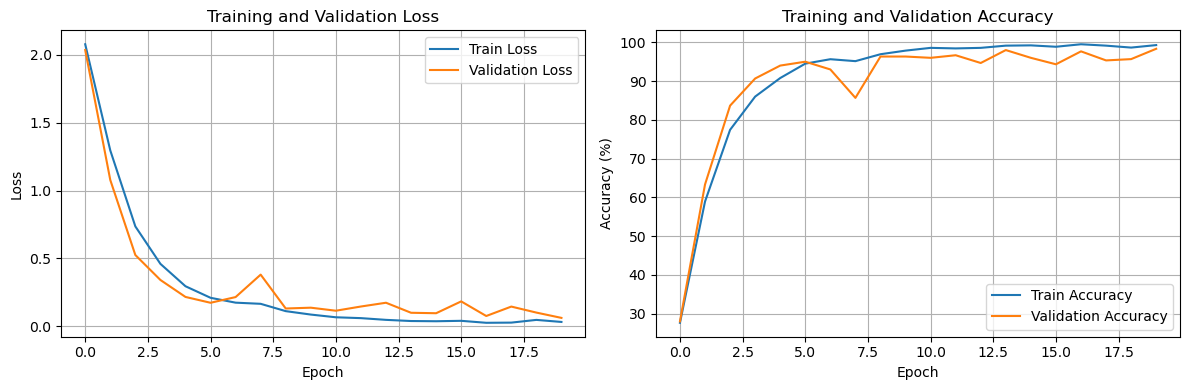

In [12]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 13. Evaluate on Test Set

In [13]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0487
Test Accuracy: 98.33%


## 14. Confusion Matrix and Classification Report

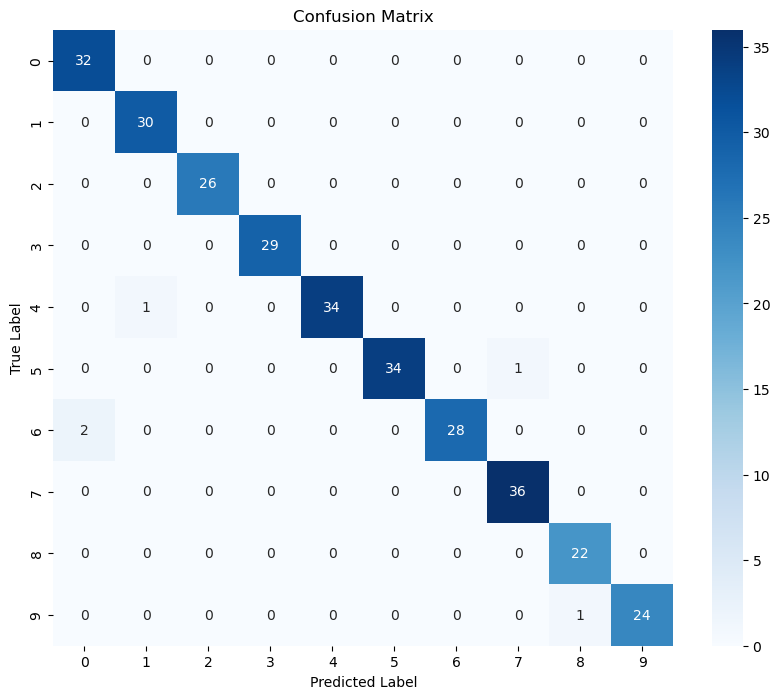


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.97      1.00      0.98        30
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        29
           4       1.00      0.97      0.99        35
           5       1.00      0.97      0.99        35
           6       1.00      0.93      0.97        30
           7       0.97      1.00      0.99        36
           8       0.96      1.00      0.98        22
           9       1.00      0.96      0.98        25

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

## 15. Visualize Predictions

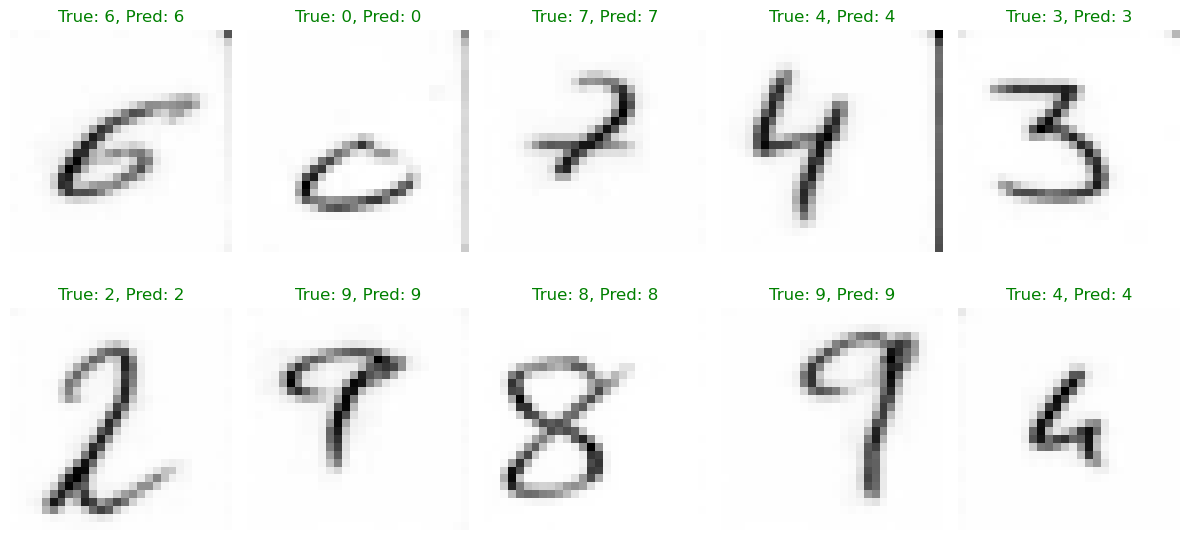

In [15]:
# Visualize some predictions
def visualize_predictions(model, dataset, device, num_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            image_tensor = image.unsqueeze(0).to(device)
            
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            
            # Denormalize the image
            image_np = image.squeeze().numpy() * 0.5 + 0.5
            
            axes[i].imshow(image_np, cmap='gray')
            axes[i].set_title(f'True: {label}, Pred: {predicted.item()}')
            axes[i].axis('off')
            
            # Color the title based on correctness
            if label == predicted.item():
                axes[i].title.set_color('green')
            else:
                axes[i].title.set_color('red')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataset, device)

## 16. Save the Final Model

In [16]:
# Save the final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'test_accuracy': test_acc
}, 'digit_cnn_final.pth')

print("Final model saved as 'digit_cnn_final.pth'")

Final model saved as 'digit_cnn_final.pth'


## 17. Inference Function for New Images

In [23]:
def predict_digit(model, image_path, device):
    """
    Predict the digit from a single image.
    
    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        device: Device to run inference on
    
    Returns:
        predicted_digit: The predicted digit (0-9)
        confidence: Confidence score of the prediction
    """
    model.eval()
    
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    image = Image.open(image_path).convert('L')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    return predicted.item(), confidence.item()

# Example usage
predicted_digit, confidence = predict_digit(model, 'test/IMG_4102.jpg', device)
print(f"Predicted Digit: {predicted_digit}, Confidence: {confidence:.2%}")

Predicted Digit: 3, Confidence: 29.06%
